<a href="https://colab.research.google.com/github/BlackCurrantDS/Data-Mining/blob/master/Blood_Cell_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

Loading dataset

In [2]:
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TRAIN/',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
    )
validation_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TEST_SIMPLE/',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256))
test_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TEST/',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256))

Found 9977 files belonging to 4 classes.
Found 71 files belonging to 4 classes.
Found 2487 files belonging to 4 classes.


In [3]:
#classes in training data
class_names = train_ds.class_names
print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


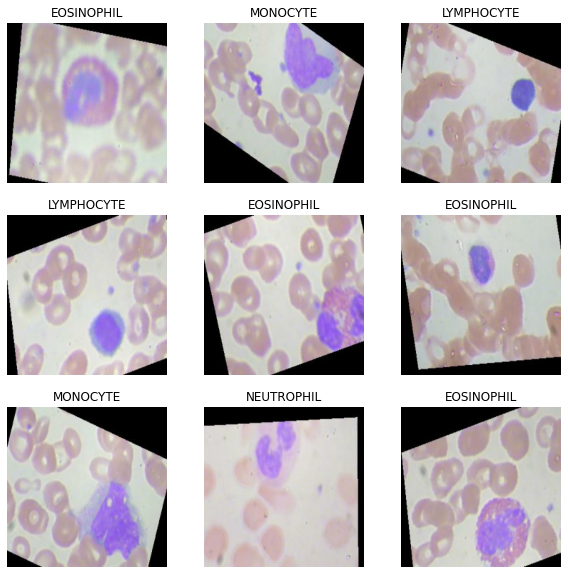

In [4]:
#checking first 10 images from training set

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

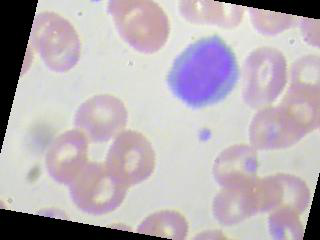

In [5]:
#randomly selecting a sample from LYMPHOCYTE
image_lymp = '/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
get_image_lymp= PIL.Image.open(image_lymp)
get_image_lymp

I can't quite find a difference between LYMPHOCYTE and MONOCYTE, so printing a random sample of MONOCYTE to find clear difference.

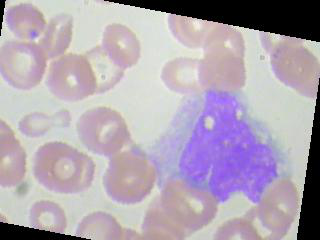

In [6]:
#randomly selecting a sample from MONOCYTE
image_mono = '/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_435.jpeg'
get_image_mono = PIL.Image.open(image_mono)
get_image_mono

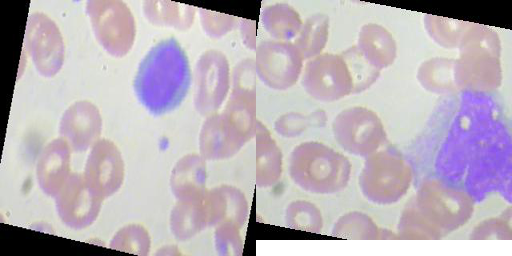

In [7]:
image1 = get_image_lymp.resize((256, 256))
image1_size = image1.size
image2_size = get_image_mono.size
new_image = PIL.Image.new('RGB',(2*image1_size[0], image1_size[1]), (256,256,256))
new_image.paste(image1,(0,0))
new_image.paste(get_image_mono,(image1_size[0],0))
new_image

LYMPHOCYTE looks littel more dense.

In [27]:
#what is the class distribution
labels = pd.read_csv('/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/labels.csv')
labels.head(5)

,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL


In [31]:
labels['Category'].value_counts()

NEUTROPHIL                207
EOSINOPHIL                 88
LYMPHOCYTE                 33
MONOCYTE                   21
BASOPHIL                    3
NEUTROPHIL, NEUTROPHIL      3
NEUTROPHIL, EOSINOPHIL      2
NEUTROPHIL, MONOCYTE        1
NEUTROPHIL,NEUTROPHIL       1
NEUTROPHIL, LYMPHOCYTE      1
EOSINOPHIL,EOSINOPHIL       1
EOSINOPHIL, LYMPHOCYTE      1
EOSINOPHIL, EOSINOPHIL      1
NEUTROPHIL,BASOPHIL         1
LYMPHOCYTE, LYMPHOCYTE      1
NEUTROPHIL,EOSINOPHIL       1
MONOCYTE, LYMPHOCYTE        1
Name: Category, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


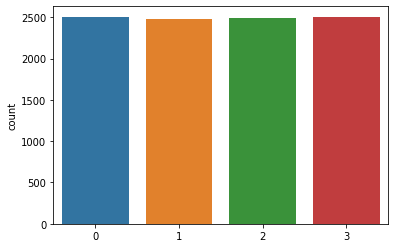

In [41]:
#train
y = np.concatenate([y for x, y in train_ds], axis=0)
sns.countplot(y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


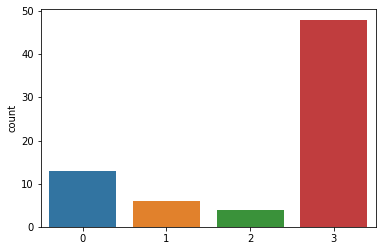

In [42]:
#validation
y = np.concatenate([y for x, y in validation_ds], axis=0)
sns.countplot(y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


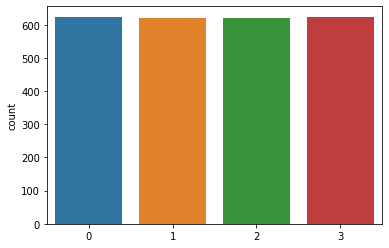

In [44]:
#test
labels = np.concatenate([y for x, y in test_ds], axis=0)
sns.countplot(labels)

In [8]:
#tensorflow recommnded perfromance options for not letting dataset a bottleneck
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
#checkpoint
checkpoint_path = "/content/drive/MyDrive/Blood Cell classification/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [21]:
#confusion Matrix
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [11]:
#model 
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0

In [14]:
epochs=1
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

312/312 [==============================] - 1403s 4s/step - loss: 1.4207 - accuracy: 0.2701 - val_loss: 1.3863 - val_accuracy: 0.1831

Epoch 00001: saving model to /content/drive/MyDrive/Blood Cell classification/training_1/cp.ckpt


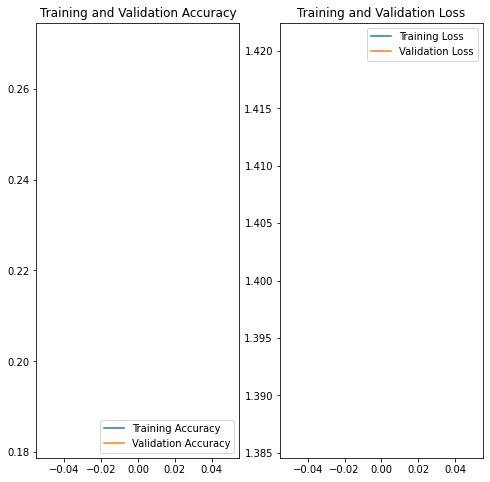

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_pred = model.predict(test_ds)
predictions = tf.argmax(y_pred, axis=1)


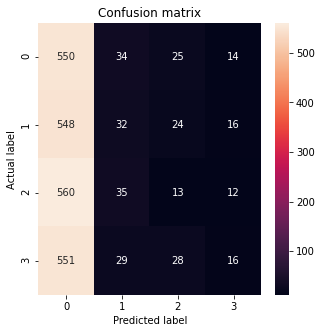

In [22]:
plot_cm(labels, predictions)